In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pathlib import Path


import matplotlib.pyplot as plt
import matplotlib.lines as lines
from tqdm.auto import tqdm

import sys

sys.path.append("../")
from agg_utils.aggregators import M4Aggregator
from agg_utils.path_conf import loc_data_dir
from agg_utils.fig_construction import (
    construct_plotly_fig,
    construct_matplotlib_fig,
    construct_bokeh_fig,
)
from agg_utils.conf import highlight_color


import matplotlib.pyplot as plt
import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df_agg_data = pd.read_csv(loc_data_dir / "agg_data.csv")
n_out_mask = pd.isna(df_agg_data.n_out)


def read_set_index_first_col(pqt_path) -> pd.Series:
    df = pd.read_parquet(pqt_path)
    df = df.set_index(df.columns[0], drop=True)
    assert len(df.columns) == 1
    return df.iloc[:, 0]


ref_data_dict = {
    f"{r.data}_{r.aggregator}_{r.n}": read_set_index_first_col(r.path)
    for _, r in tqdm(df_agg_data[n_out_mask].iterrows(), total=sum(n_out_mask))
}


  0%|          | 0/24 [00:00<?, ?it/s]

## Comparing the toolkits

/tmp/ipykernel_3877209/3950659822.py:20: FutureWarning:

Treating integers as positional in Series.__setitem__ with a Float64Index is deprecated. In a future version, `series[an_int] = val` will insert a new key into the Series. Use `series.iloc[an_int] = val` to treat the key as positional.

/tmp/ipykernel_3877209/3950659822.py:21: FutureWarning:

Treating integers as positional in Series.__setitem__ with a Float64Index is deprecated. In a future version, `series[an_int] = val` will insert a new key into the Series. Use `series.iloc[an_int] = val` to treat the key as positional.



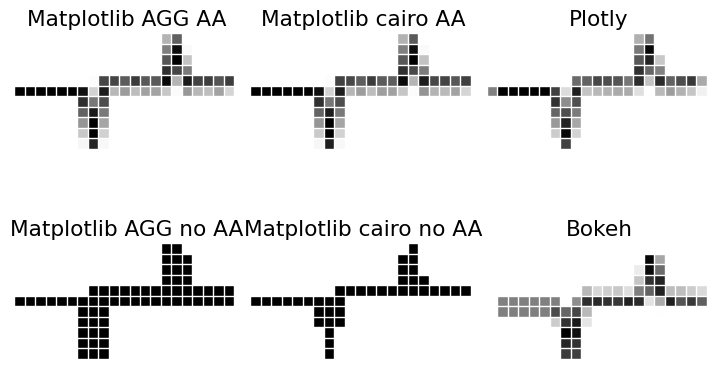

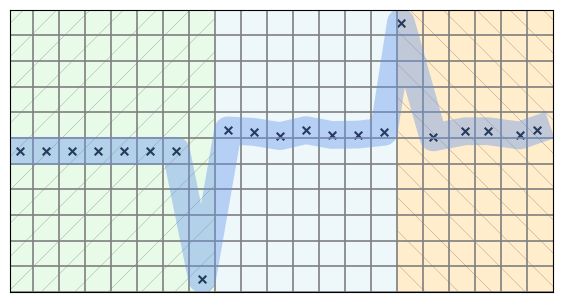

In [18]:
drawstyle = "default"
line_width = 1
fig_width, fig_height = 21, 11
neg_peak_index, switch_index, pos_peak_index = 7, 8, 15

# make the flat line lie perfectly in the middle of the range bins
series = pd.Series(data=np.ones(fig_width) * (fig_height - 1) / 2 + 0.5)

# make sure that the indexes lie perfectly in the middle of the range bins
series.index += 0.5

# make the second flat line lie somewhere at the boundary of range bins
# (25 percent in lower range bin, 75 percent in upper range bin)
series.iloc[switch_index:] = (
    np.ones(len(series) - switch_index) * (fig_height - 1) / 2 + 0.5 + 0.66
) + np.random.randn(len(series) - switch_index) * 0.1

# series.iloc[pos_peak_index:] += np.random.randn(len(series) - pos_peak_index) * 0.15

series[neg_peak_index] = 0.5
series[pos_peak_index] = fig_height - 0.5

# alter the series index to make sure that the peak is at the middle of the
# pixel boundaries
si = series.index.to_list()
# si[switch_index:] = si[switch_index:] + np.random.randn(len(si) - switch_index) * 0.1
si[pos_peak_index:] = (
    si[pos_peak_index:] + np.random.randn(len(si) - pos_peak_index) * 0.1
)
si[pos_peak_index] = pos_peak_index - 1 + 0.5 + 0.66
series.index = si

ylim = 0, fig_height
xlim = 0, fig_width


if True:
    construct_matplotlib_fig(
        series.index,
        series.values,
        save_path="tmp_images/matplotlib.png",
        **dict(aa=True, xlim=xlim, ylim=ylim, line_width_px=line_width),
        **dict(drawstyle=drawstyle, width=fig_width, height=fig_height),
        backend="agg",
    )

    # no Anti-Aliasing
    construct_matplotlib_fig(
        series.index,
        series.values,
        aa=False,
        save_path="tmp_images/matplotlib_no_aa.png",
        **dict(xlim=xlim, ylim=ylim, line_width_px=line_width),
        **dict(drawstyle=drawstyle, width=fig_width, height=fig_height),
        backend="agg",
    )

    # plt.(newbackend='cairo')
    construct_matplotlib_fig(
        series.index,
        series.values,
        save_path="tmp_images/matplotlib_cairo.png",
        **dict(aa=True, xlim=xlim, ylim=ylim, line_width_px=line_width),
        **dict(drawstyle=drawstyle, width=fig_width, height=fig_height),
        backend="cairo",
    )

    # no Anti-Aliasing
    construct_matplotlib_fig(
        series.index,
        series.values,
        save_path="tmp_images/matplotlib_cairo_no_aa.png",
        **dict(aa=False, xlim=xlim, ylim=ylim, line_width_px=line_width),
        **dict(drawstyle=drawstyle, width=fig_width, height=fig_height),
        backend="cairo",
    )
    construct_plotly_fig(
        series.index,
        series.values,
        save_path="tmp_images/plotly.png",
        **dict(aa=True, xlim=xlim, ylim=ylim, line_width=line_width),
        line_shape={"steps-mid": "vhv", "default": "linear"}[drawstyle],
        width=fig_width,
        height=fig_height,
    )

    construct_bokeh_fig(
        series.index,
        series.values,
        save_path="tmp_images/bokeh.png",
        xlim=xlim,
        ylim=ylim,
        line_width=line_width,
        line_shape=drawstyle,
        width=fig_width,
        height=fig_height,
    )

    mpl_arr = plt.imread("tmp_images/matplotlib.png")
    mpl_arr_no_aa = plt.imread("tmp_images/matplotlib_no_aa.png")
    mpl_arr_c = plt.imread("tmp_images/matplotlib_cairo.png")
    mpl_arr_c_no_aa = plt.imread("tmp_images/matplotlib_cairo_no_aa.png")
    ply_arr = plt.imread("tmp_images/plotly.png")
    bkh_arr = plt.imread("tmp_images/bokeh.png")

    arr_name_list = [
        ("Matplotlib AGG AA", mpl_arr),
        ("Matplotlib cairo AA", mpl_arr_c),
        ("Plotly", ply_arr),
        ("Matplotlib AGG no AA", mpl_arr_no_aa),
        ("Matplotlib cairo no AA", mpl_arr_c_no_aa),
        ("Bokeh", bkh_arr),
    ]

    fig, axs = plt.subplots(2, len(arr_name_list) // 2, figsize=(9, 5))
    for i, (arr_name, arr) in enumerate(arr_name_list):
        row_idx = i // (len(arr_name_list) // 2)
        col_idx = i % (len(arr_name_list) // 2)

        axs[row_idx, col_idx].imshow((255 * arr).astype(np.uint8), vmin=0, vmax=255)
        axs[row_idx, col_idx].set_title(arr_name)
        axs[row_idx, col_idx].set_frame_on(False)

        ax = axs[row_idx, col_idx]
        # Major ticks
        ax.set_xticks(np.arange(-0.05, arr.shape[1], 1))
        ax.set_yticks(np.arange(-0.001, arr.shape[0], 1))

        # Minor ticks
        ax.set_xticks(np.arange(-0.5, arr.shape[1], 1), minor=True)
        ax.set_yticks(np.arange(-0.5, arr.shape[0], 1), minor=True)

        # Gridlines based on minor ticks
        ax.grid(which="minor", color="white", linestyle="-", linewidth=1)
        ax.tick_params(which="minor", bottom=False, left=False)

        # hid the ticks but keep the grid
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(which="major", bottom=False, left=False)

plt.subplots_adjust(hspace=0.2, wspace=0.05)
plt.savefig("aggregators_v2.pdf")
plt.show()

import matplotlib as mpl

mpl.rcParams["hatch.linewidth"] = 0.1  # previous pdf hatch linewidth
factor = 3
fig, ax = plt.subplots(1, 1, figsize=(fig_width / factor, fig_height / factor))


# Major ticks
ax.set_xticks(np.arange(0, fig_width, 1))
ax.set_yticks(np.arange(0, fig_height, 1))


# Gridlines based on minor ticks
ax.grid(color="grey", linestyle="-", linewidth=1.2)
ax.tick_params(which="minor", bottom=False, left=False)

# set te hatch linewidth
alpha = 0.2
ax.axvspan(
    0, neg_peak_index + 1, facecolor="lightgreen", hatch="/", linewidth=0.5, alpha=alpha
)
ax.axvspan(neg_peak_index + 1, pos_peak_index, facecolor="lightblue", alpha=alpha)
ax.axvspan(pos_peak_index, fig_width, facecolor="orange", hatch="\\", alpha=alpha)

ax.scatter(series.index, series.values, s=30, c="black", marker="x")
ax.add_line(
    lines.Line2D(
        series.index,
        series.values,
        lw=20,
        c="cornflowerblue",
        drawstyle="default",
        alpha=0.4,
        antialiased=True,
    )
)

ax.set_xlim(0.1, xlim[-1])
ax.set_ylim(ylim)

# hid the ticks but keep the grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(which="major", bottom=False, left=False)
plt.show()

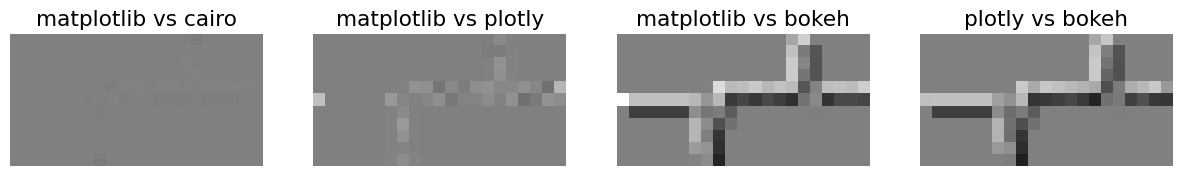

In [24]:
mpl_slice = (255 * mpl_arr[:, :, 3]).astype(int)
cairo_slice = (255 * mpl_arr_c[:, :, 3]).astype(int)
bkh_slice = (255 - (bkh_arr[:, :, 1] * 255)).astype(int)
ply_slice = (255 - (ply_arr[:, :, 1] * 255)).astype(int)

if mpl_slice.dtype == bool:
    vmin, vmax = 0, 1
else:
    vmin, vmax = -255, 255

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
im = ax[0].imshow(mpl_slice - cairo_slice, vmin=vmin, vmax=vmax, cmap='gray')
ax[0].set_title("matplotlib vs cairo")
ax[0].axis("off")
ax[0].set_frame_on(False)
ax[1].imshow(mpl_slice - ply_slice, vmin=vmin, vmax=vmax, cmap='gray')
ax[1].set_title("matplotlib vs plotly")
ax[1].axis("off")
ax[1].set_frame_on(False)
ax[2].imshow(mpl_slice - bkh_slice, vmin=vmin, vmax=vmax, cmap='gray')
ax[2].set_title("matplotlib vs bokeh")
ax[2].axis("off")
ax[2].set_frame_on(False)
ax[3].imshow(ply_slice - bkh_slice, vmin=vmin, vmax=vmax, cmap='gray')
ax[3].set_title("plotly vs bokeh")
ax[3].axis("off")
ax[3].set_frame_on(False)


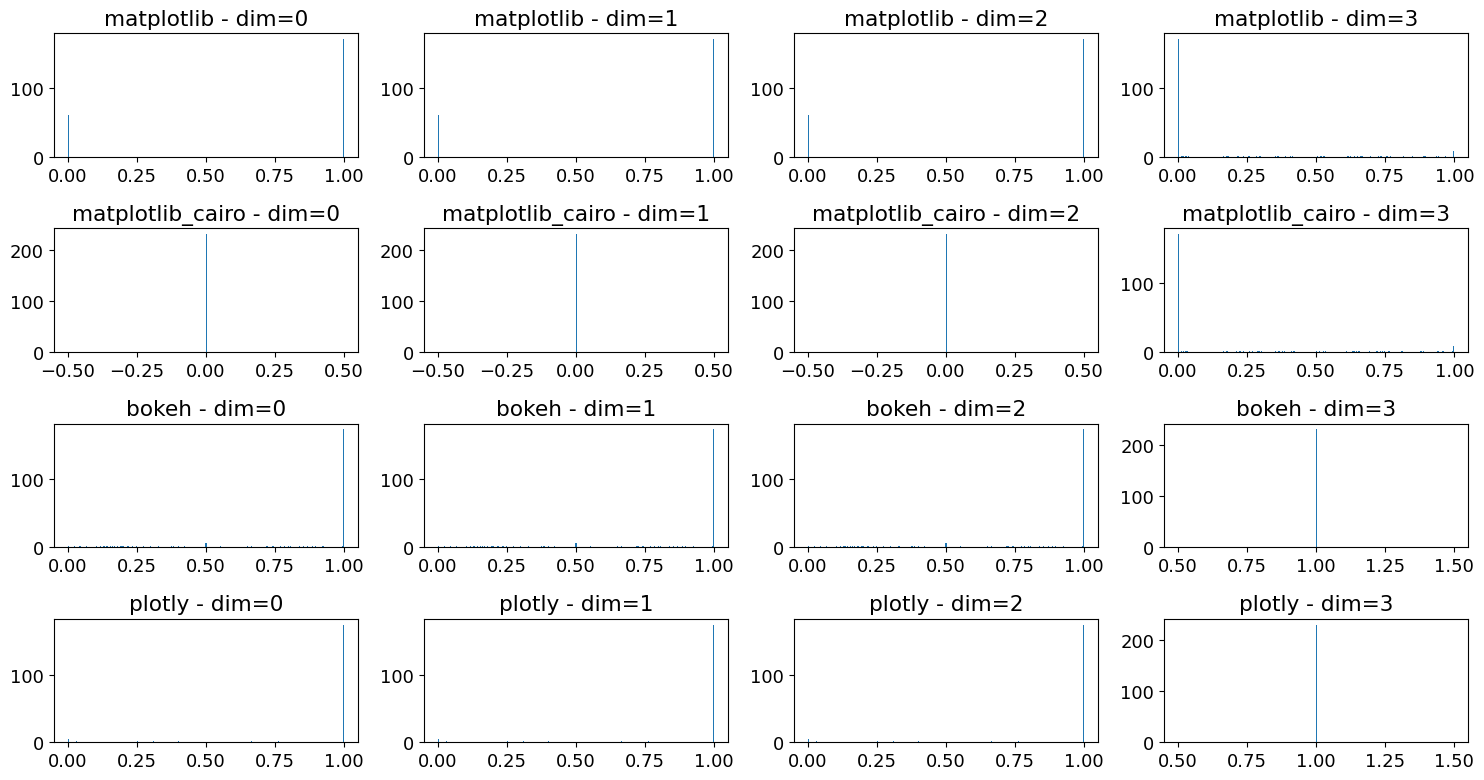

In [28]:
arr_str_zip = list(
    zip(
        ["matplotlib", "matplotlib_cairo", "bokeh", "plotly"],
        [mpl_arr, mpl_arr_c, bkh_arr, ply_arr],
    )
)

fig, ax = plt.subplots(len(arr_str_zip), 4, figsize=(15, 8))
for row_idx, (name, arr) in enumerate(arr_str_zip):
    for col_idx in range(4):
        ax[row_idx, col_idx].hist(arr[:, :, col_idx].flatten(), bins=256)
        ax[row_idx, col_idx].set_title(f"{name} - dim={col_idx}")
plt.tight_layout()
plt.show()
